[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# OpenAI GPT-4o fine-tuning
---

## Setup

### Configure your API keys

To fine-tune GPT-4o, you need to provide your OpenAI API key and Roboflow API key. Follow these steps:

- Open your [`OpenAI Settings`](https://platform.openai.com/settings) page. Click `User API keys` then `Create new secret key` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store OpenAI API key under the name `OPENAI_API_KEY`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

## Install dependencies

In [1]:
!pip install -q openai roboflow supervision maestro==0.2.0rc5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.5/383.5 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.3/151.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━

## Download dataset

In [2]:
from roboflow import Roboflow
from google.colab import userdata

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

workspace = rf.workspace("roboflow-jvuqo")
project = workspace.project("poker-cards-fmjio")
version = project.version(3)
dataset = version.download("openai")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to poker-cards-3 in openai:: 100%|██████████| 5/5 [00:00<00:00, 1049.78it/s]


In [5]:
!wc -l {dataset.location}/_annotations.train.jsonl
!wc -l {dataset.location}/_annotations.valid.jsonl
!wc -l {dataset.location}/_annotations.test.jsonl

353 /content/poker-cards-3/_annotations.train.jsonl
43 /content/poker-cards-3/_annotations.valid.jsonl
43 /content/poker-cards-3/_annotations.test.jsonl


In [6]:
!head -n 1 {dataset.location}/_annotations.train.jsonl

{"messages":[{"role":"system","content":"You are a helpful assistant."},{"role":"user","content":"detect 10 of clubs ; 10 of diamonds ; 10 of hearts ; 10 of spades ; 2 of clubs ; 2 of diamonds ; 2 of hearts ; 2 of spades ; 3 of clubs ; 3 of diamonds ; 3 of hearts ; 3 of spades ; 4 of clubs ; 4 of diamonds ; 4 of hearts ; 4 of spades ; 5 of clubs ; 5 of diamonds ; 5 of hearts ; 5 of spades ; 6 of clubs ; 6 of diamonds ; 6 of hearts ; 6 of spades ; 7 of clubs ; 7 of diamonds ; 7 of hearts ; 7 of spades ; 8 of clubs ; 8 of diamonds ; 8 of hearts ; 8 of spades ; 9 of clubs ; 9 of diamonds ; 9 of hearts ; 9 of spades ; ace of clubs ; ace of diamonds ; ace of hearts ; ace of spades ; jack  of clubs ; jack of diamonds ; jack of hearts ; jack of spades ; king of clubs ; king of diamonds ; king of hearts ; king of spades ; queen of clubs ; queen of diamonds ; queen of hearts ; queen of spades"},{"role":"user","content":[{"type":"image_url","image_url":{"url":"https://transform.roboflow.com/GGqN

In [8]:
!head -n 200 {dataset.location}/_annotations.train.jsonl > {dataset.location}/_annotations.train.200.jsonl

## Run GPT-4o fine-tuning

**NOTE:** At the time of publishing this notebook, only the `gpt-4o-2024-08-06` model can be fine-tuned with vision datasets.

In [7]:
# @title Initiate OpenAI client

from openai import OpenAI
from google.colab import userdata

OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

client = OpenAI(api_key=OPENAI_API_KEY)

In [11]:
# @title Upload a training and validation file

training_file_upload_response = client.files.create(
    file=open(f"{dataset.location}/_annotations.train.200.jsonl", "rb"),
    purpose="fine-tune"
)

validation_file_upload_response = client.files.create(
    file=open(f"{dataset.location}/_annotations.valid.jsonl", "rb"),
    purpose="fine-tune"
)

print("treaining file response:", training_file_upload_response)
print("validation file response:", validation_file_upload_response)

treaining file response: FileObject(id='file-BjOpHLaLmABPRJN3jkZhm5Zr', bytes=268981, created_at=1727964029, filename='_annotations.train.200.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)
validation file response: FileObject(id='file-YY0WSEPFPmlXtfU6de68Znff', bytes=59281, created_at=1727964030, filename='_annotations.valid.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)


In [12]:
# @title Create a fine-tuned model

import re

def process_suffix(text: str) -> str:
    """
    Converts a string into kebab-case, where spaces are replaced with hyphens
    and all letters are lowercase.

    Args:
        text (str): The input string to be converted. Typically, words are
          separated by spaces.

    Returns:
        str: The kebab-case version of the input string, where spaces are
          replaced by hyphens and the text is lowercase.

    Example:
        >>> process_suffix("Focal Length")
        'focal-length'
    """
    return re.sub(r'\s+', '-', text.strip()).lower()


fine_tuning_response = client.fine_tuning.jobs.create(
    training_file=training_file_upload_response.id,
    validation_file=validation_file_upload_response.id,
    suffix=process_suffix(dataset.name),
    model="gpt-4o-2024-08-06"
)

fine_tuning_response

FineTuningJob(id='ftjob-PNVsFo2wiQRpAOMjpTaNAZo8', created_at=1727964041, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-4o-2024-08-06', object='fine_tuning.job', organization_id='org-sLGE3gXNesVjtWzgho17NkRy', result_files=[], seed=349557411, status='validating_files', trained_tokens=None, training_file='file-BjOpHLaLmABPRJN3jkZhm5Zr', validation_file='file-YY0WSEPFPmlXtfU6de68Znff', estimated_finish=None, integrations=[], user_provided_suffix='poker-cards')

⚠️ After you've started a fine-tuning job, it may take some time to complete. Your job may be queued behind other jobs in our system, and training a model can take minutes or hours depending on the model and dataset size. After the model training is completed, the user who created the fine-tuning job will receive an email confirmation.

In addition to creating a fine-tuning job, you can also list existing jobs, retrieve the status of a job, or cancel a job.

In [18]:
# @title Check training job status

status_response = client.fine_tuning.jobs.retrieve(fine_tuning_response.id)

status_response

FineTuningJob(id='ftjob-PNVsFo2wiQRpAOMjpTaNAZo8', created_at=1727964041, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-2024-08-06:personal:poker-cards:AEHLLzg9', finished_at=1727966620, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=2), model='gpt-4o-2024-08-06', object='fine_tuning.job', organization_id='org-sLGE3gXNesVjtWzgho17NkRy', result_files=['file-ED8zjXuHIPeSBXTLCsJN8Qez'], seed=349557411, status='succeeded', trained_tokens=655614, training_file='file-BjOpHLaLmABPRJN3jkZhm5Zr', validation_file='file-YY0WSEPFPmlXtfU6de68Znff', estimated_finish=None, integrations=[], user_provided_suffix='poker-cards')

**NOTE:** When the training status changes to `succeeded`, the model is ready to use.

In [15]:
# @title Load test dataset

import random
from torch.utils.data import Dataset
from maestro.trainer.common.utils.file_system import read_jsonl

class JSONLDataset(Dataset):
    """A dataset class for loading and managing JSONL data in a PyTorch-compatible format.

    This class allows loading JSONL files, shuffling the data, and accessing
    individual data points using standard PyTorch Dataset interfaces.
    """

    @classmethod
    def from_jsonl_file(cls, path: str):
        """Loads data from a JSONL file, shuffles it, and returns a dataset instance.

        Args:
            path (str): The file path to the JSONL file.

        Returns:
            JSONLDataset: An instance of the JSONLDataset class loaded with the JSON data.
        """
        file_content = read_jsonl(path=path)
        random.shuffle(file_content)
        return cls(jsons=file_content)

    def __init__(self, jsons: list[dict]) -> None:
        """Initializes the dataset with a list of JSON objects.

        Args:
            jsons (list[dict]): A list of JSON objects, each represented as a dictionary.
        """
        self.jsons = jsons

    def __getitem__(self, index):
        """Fetches a specific item from the dataset.

        Args:
            index (int): The index of the item to retrieve.

        Returns:
            dict: A dictionary representing the JSON object at the specified index.
        """
        return self.jsons[index]

    def __len__(self) -> int:
        """Returns the number of items in the dataset.

        Returns:
            int: The total number of JSON objects in the dataset.
        """
        return len(self.jsons)

    def shuffle(self) -> None:
        """Shuffles the JSON objects in the dataset.

        This method modifies the dataset in place, changing the order of the JSON objects.
        """
        random.shuffle(self.jsons)


def extract_image_url(data):
    """Extracts the first image URL from a list of messages in a dataset.

    The function searches through messages to find an image URL
    where the 'role' is 'user' and 'content' is a list containing items
    with a 'type' of 'image_url'.

    Args:
        data (list[dict]): A list of message dictionaries.

    Returns:
        str or None: The image URL if found, otherwise None.
    """
    for message in data:
        if message['role'] == 'user' and isinstance(message['content'], list):
            for item in message['content']:
                if item.get('type') == 'image_url':
                    return item['image_url']['url']
    return None


test_dataset = JSONLDataset.from_jsonl_file(f"{dataset.location}/_annotations.test.jsonl")

**NOTE:** When querying the model, we need to remove the last element of the messages list, which contains the expected model response.

In [16]:
test_dataset[0]['messages']

[{'role': 'system', 'content': 'You are a helpful assistant.'},
 {'role': 'user',
  'content': 'detect 10 of clubs ; 10 of diamonds ; 10 of hearts ; 10 of spades ; 2 of clubs ; 2 of diamonds ; 2 of hearts ; 2 of spades ; 3 of clubs ; 3 of diamonds ; 3 of hearts ; 3 of spades ; 4 of clubs ; 4 of diamonds ; 4 of hearts ; 4 of spades ; 5 of clubs ; 5 of diamonds ; 5 of hearts ; 5 of spades ; 6 of clubs ; 6 of diamonds ; 6 of hearts ; 6 of spades ; 7 of clubs ; 7 of diamonds ; 7 of hearts ; 7 of spades ; 8 of clubs ; 8 of diamonds ; 8 of hearts ; 8 of spades ; 9 of clubs ; 9 of diamonds ; 9 of hearts ; 9 of spades ; ace of clubs ; ace of diamonds ; ace of hearts ; ace of spades ; jack  of clubs ; jack of diamonds ; jack of hearts ; jack of spades ; king of clubs ; king of diamonds ; king of hearts ; king of spades ; queen of clubs ; queen of diamonds ; queen of hearts ; queen of spades'},
 {'role': 'user',
  'content': [{'type': 'image_url',
    'image_url': {'url': 'https://transform.robo

In [19]:
# @title Run inference using fine-tuned model

completion = client.chat.completions.create(
    model=status_response.fine_tuned_model,
    messages=test_dataset[0]['messages'][:-1]
)

completion.choices[0].message

ChatCompletionMessage(content='<loc0432><loc0121><loc0882><loc0300> 5 of hearts ; <loc0380><loc0239><loc0816><loc0437> 6 of hearts ; <loc0298><loc0396><loc0768><loc0613> 7 of hearts ; <loc0224><loc0571><loc0748><loc0871> 8 of hearts', refusal=None, role='assistant', function_call=None, tool_calls=None)

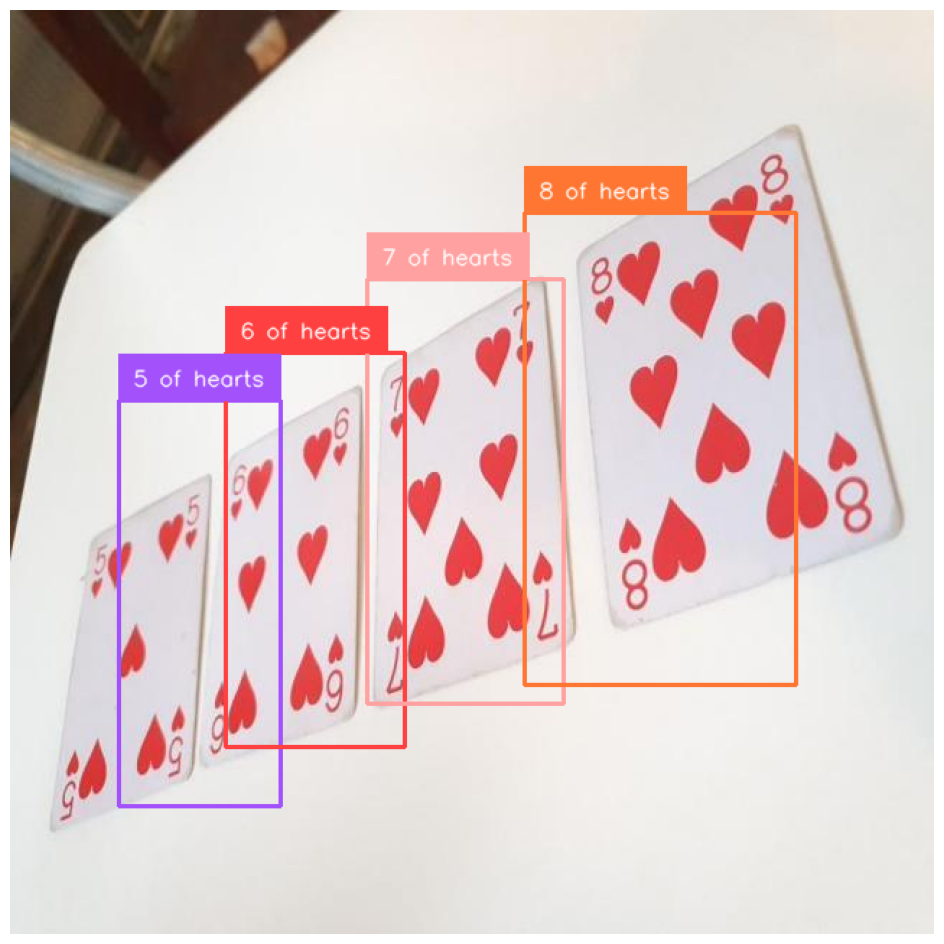

In [20]:
# @title Post-process inference result

import requests
import supervision as sv
from PIL import Image

URL = extract_image_url(test_dataset[0]['messages'])

image = Image.open(requests.get(URL, stream=True).raw)
detections = sv.Detections.from_lmm(
    lmm=sv.LMM.PALIGEMMA,
    result=completion.choices[0].message.content,
    resolution_wh=image.size
)

box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(
    scene=image,
    detections=detections
)
annotated_image = label_annotator.annotate(
    scene=annotated_image,
    detections=detections
)

sv.plot_image(annotated_image)

  0%|          | 0/9 [00:00<?, ?it/s]

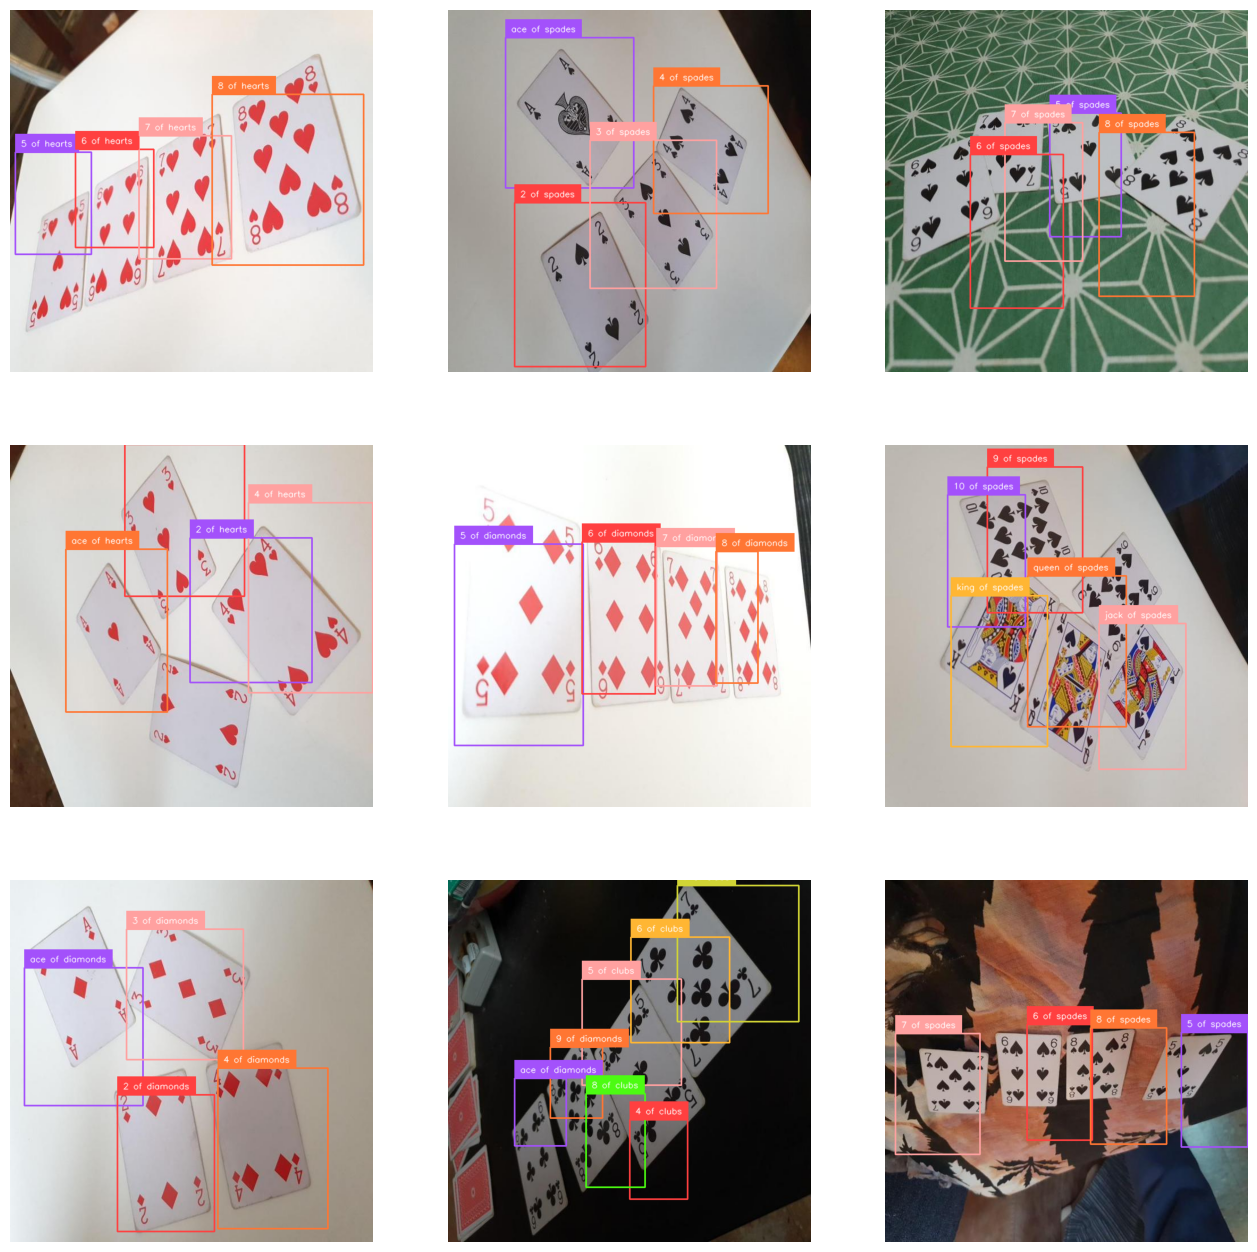

In [21]:
# @title Run inference on multiple images

from tqdm.notebook import tqdm

SAMPLE = 9

annotated_images = []

for i in tqdm(range(SAMPLE)):
    completion = client.chat.completions.create(
        model=status_response.fine_tuned_model,
        messages=test_dataset[i]['messages'][:-1]
    )

    url = extract_image_url(test_dataset[i]['messages'])

    image = Image.open(requests.get(url, stream=True).raw)
    detections = sv.Detections.from_lmm(
        lmm=sv.LMM.PALIGEMMA,
        result=completion.choices[0].message.content,
        resolution_wh=image.size
    )

    box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
    label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

    annotated_image = image.copy()
    annotated_image = box_annotator.annotate(
        scene=image,
        detections=detections
    )
    annotated_image = label_annotator.annotate(
        scene=annotated_image,
        detections=detections
    )
    annotated_images.append(annotated_image)

sv.plot_images_grid(annotated_images, grid_size=(3, 3), size=(16, 16))